<a href="https://colab.research.google.com/github/helberjf/Helber/blob/main/Geoestastica_Atividade_Final_Helber_Soares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade Final Geoestatística

Usando os arquivos baseroubos.cv e Distrito Sao Paulo.zip responda o que se pede abaixo. O arquivo baseroubos.csv contém o ano, o mês e as coordenadas (latitude e longitude) da ocorrência de roubo em São Paulo. As coordenadas foram obtidas por meio de GPS (WGS84). O arquivo Distrito Sao Paulo.zip possui o contorno da cidade de São Paulo com seus distritos.

1) Faça um mapa de pontos dos roubos da cidade de São Paulo no ano de 2016 estático.

2) Faça um mapa de pontos marcado dos roubos da cidade de São Paulo no ano de 2016. Use o mês como marca.

3) Faça um mapa de pontos dos roubos da cidade de São Paulo no ano de 2016
interativo. Quando o mouse passar pelos pontos deseja-se saber o ano e o mês de ocorrência do roubo.

4) Estime a intensidade do processo, usando um kernel gaussiano e o raio estimado pelo método scott.

5) Avalie por meio de um histograma a distância do vizinho mais próximo.

6) Estime a função G de Ripley do processo. Você diria que existe agrupamento dos pontos?

7) Usando o algoritmo DBSCAN encontre os clusters de ponto. Use a seguinte configuração de cluster: 1200 m e 50 pontos.

In [ ]:
pip  install libpysal

In [ ]:
pip install pointpats

In [ ]:
pip install contextily

In [ ]:
#Ativando pacotes
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyproj
from PIL import Image
import plotly.express as px
import contextily as ctx
import libpysal as ps
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

# 1) Faça um mapa de pontos dos roubos da cidade de São Paulo no ano de 2016 estático.

In [ ]:
#Importando o shapefile de Houston (Houston.zip)
SPshp = gpd.read_file(filename = "Distrito Sao Paulo.zip")

#Apresentando as linhas iniciais do dataframe existente dentro do shapefile
SPshp.head()

In [ ]:
#Visualizando informações sobre o objeto
SPshp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CLASSID     96 non-null     float64 
 1   FEATID      96 non-null     float64 
 2   REVISIONNU  96 non-null     float64 
 3   NOME_DIST   96 non-null     object  
 4   SIGLA_DIST  96 non-null     object  
 5   COD_DIST    96 non-null     object  
 6   COD_SUB     96 non-null     object  
 7   DATA_CRIAC  96 non-null     object  
 8   USUARIO_ID  96 non-null     float64 
 9   geometry    96 non-null     geometry
dtypes: float64(4), geometry(1), object(5)
memory usage: 7.6+ KB


<Axes: >

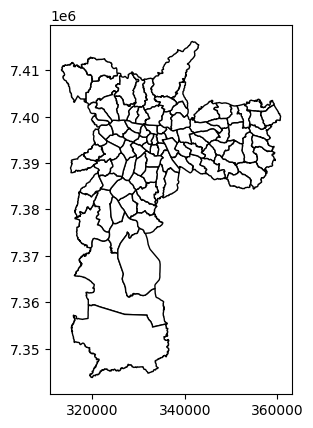

In [ ]:
#Plotando o shape
SPshp.plot(color = 'white',
           edgecolor = 'black')

In [ ]:
#Visualizando o Sistema de Referência de Coordenadas (CRS)
SPshp.crs

<Projected CRS: EPSG:29193>
Name: SAD69 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: South American Datum 1969
- Ellipsoid: GRS 1967 Modified
- Prime Meridian: Greenwich

In [ ]:
#Importando o arquivo baseroubos.csv
dados_crime = pd.read_csv(filepath_or_buffer = "baseroubos.csv",
                          sep = ";",
                          decimal = ",")
#Visualizando as linhas iniciais do objeto
dados_crime.head()

In [ ]:
#Visualizando informações sobre o objeto
dados_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ANO        4818 non-null   int64  
 1   MES        4818 non-null   int64  
 2   LATITUDE   4818 non-null   float64
 3   LONGITUDE  4818 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 150.7 KB


In [ ]:
#Definindo a mudança do Sistema de Referência de Coordenadas desejada
transformacao = pyproj.Transformer.from_crs(crs_from = "EPSG:4326",
                                            crs_to = "EPSG:29193",
                                            always_xy = True)

#Aplicando a transformação nas coordenadas originais
longT, latT = transformacao.transform(dados_crime.LONGITUDE,dados_crime.LATITUDE)

#Incluindo as variáveis logT e latT no objeto dados_sinistro_mod
dados_crime["longT"] = longT
dados_crime["latT"] = latT

#Visualizando as linhas iniciais do objeto
dados_crime.head()

,ANO,MES,LATITUDE,LONGITUDE,longT,latT
0,2016,1,-23.53394,-46.63710,332924.111329,7.396463e+06
1,2016,2,-23.50761,-46.38175,358966.832064,7.399653e+06
2,2016,2,-23.50374,-46.42552,354492.995607,7.400038e+06
3,2016,7,-23.68496,-46.75623,320965.764313,7.379595e+06
4,2016,5,-23.63281,-46.71007,325604.379326,7.385428e+06


In [ ]:
dados_crime.tail()

,ANO,MES,LATITUDE,LONGITUDE,longT,latT
4813,2016,6,-23.59945,-46.45132,351965.607154,7.389414e+06
4814,2016,2,-23.60721,-46.63572,333157.663730,7.388351e+06
4815,2016,2,-23.53784,-46.44013,353038.919025,7.396247e+06
4816,2016,6,-23.55574,-46.55220,341618.617398,7.394146e+06
4817,2016,2,-23.52021,-46.70415,326060.004043,7.397904e+06


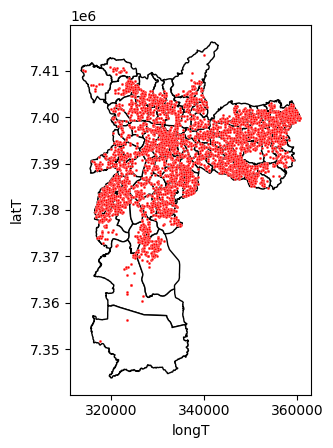

In [ ]:
#Plotando um mapa de pontos

SPshp.plot(color = "white",
           edgecolor = "black")
ax = sns.scatterplot(x = "longT",
                     y = "latT",
                     color = "red",
                     data = dados_crime,
                     s = 4,
                     hue = None)


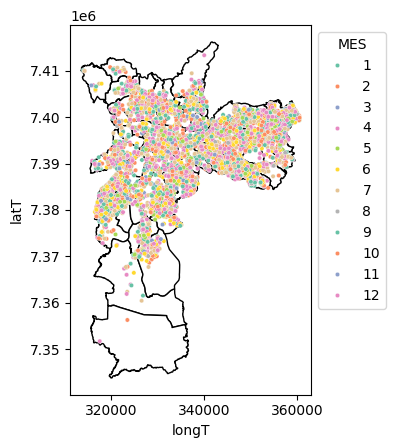

In [ ]:
#Plotando um mapa de pontos indicando os tipos de crime

SPshp.plot(color = "white",
           edgecolor = "black")
ax = sns.scatterplot(x = "longT",
                     y = "latT",
                     data = dados_crime,
                     s = 10,
                     hue = "MES",
                     palette = "Set2")
sns.move_legend(obj = ax,
                loc = "upper left",
                bbox_to_anchor = (1, 1))

In [ ]:
#Plotando um mapa de pontos interativo
mapa_pontos = px.scatter_mapbox(data_frame = dados_crime,
                                lon = "LONGITUDE",
                                lat = "LATITUDE",
                                hover_name = "ANO",
                                hover_data = ["MES"],
                                color_discrete_sequence=["blue"],
                                zoom = 10,
                                height = 1000)
mapa_pontos.update_layout(mapbox_style = "open-street-map")
mapa_pontos.update_layout(margin = {"r":0,"t":0,"l":0,"b":0})
mapa_pontos.show()

Text(0.5, 1.0, 'Kernel Gaussiano com raio estimado pelo método scott')

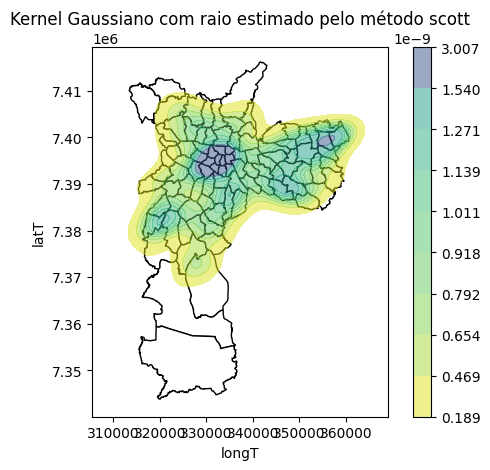

In [ ]:
#Plotando um mapa de pontos
SPshp.plot(color = "white",
           edgecolor = 'black')
sns.kdeplot(x = "longT",
            y = "latT",
            data = dados_crime,
            fill = True,
            alpha = 0.5,
            cbar = True,
            cmap = "viridis_r",
            bw_method = "scott").set_title("Kernel Gaussiano com raio estimado pelo método scott")

# plot - função para plotar o shapefile
# kdeplot - função que estima a intensidade
## principais argumentos
# color - define a cor do preenchimento do maps
# edgecolor - define a cor das linhas de contorno
# x - coordenada de longitude
# y - coordenada de latitude
# data - base de dados com as coordenadas
# fill - argumento lógico, se deve preencher a área da densidade estimada
# alpha - opacidade (número entre 0 e 1)
# cbar - argumento lógico, se deve incluir a barra lateral
# height - altura da janela qu eo mapa será apresentado
# cmap - paleta de cores
# bw_method - o método ou o valor do raio